In [257]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import norm, binom, bernoulli
from matplotlib import pyplot as plt

# Making comparisons

Experimental science is about measuring differences. So scientists are obsessed with making comparisons. They are for instance interested in:

- which of two competing drugs work better
- whether a drug is more effective than placebo
- if a new teaching aid improve grades
- if their newly developed algorithm is actually better than a baseline

## Curing colds

<img src="cure_at_cold.jpg" width="450"/>

*Friendly Pharmaceuticals* has developed a drug that supposedly cures the common cold faster. They set up a randomized controlled experiment, enrolling 40 participants, which are randomly assigned to either treatment or a placebo. 

You already know `pandas`. Can you just use `groupby()` to calculate the means and be done with it?

Say you observe a positive result. The people in the treatment group recover, on average, one day faster compared to the control group. What might cause that result to be a statistical fluke in the example above?

## What is a $p$-value?

Assume that your result is a fluke (there is actually no effect of the drug). 

> Given this assumption, what is the probability of seeing a result *at least as extreme* as the one you observed?

The $p$-value provides the answer to this question.

The p-value is a measure of surprisal. 

A low $p$-value indicates that is the result you're getting is weird if nothing is going on.

## What a $p$-value is not

### A confirmation

A low $p$-value doesn't mean that you're right.

### An assessment

A low $p$-value doesn't entail that your result is important.

## How $p$-values are used

### Your question

Is there *really* a difference between the drugs? 

### Traditional answer


Yes, if $p < 0.05$

### Interpretation

The observed data is **not** consistent with the drug **not** working.

## Two roads to significance

### Large effects in small data

You can measure a huge effect, even in a small sample. 

### Small effects in large data

In a huge sample, you can measure a very small effect to a very high precision.

I.e. with enough data you can always get significant results.

## Insignificance

<img src="tiny_animal.jpg"/>

What does it mean if your result is not significant?

Possibly not a thing.

## Two schools of significance testing

### Ronald A. Fisher

<img src="ronald_fisher.gif"/>

- Rule-of-thumb to check the validity of a result
- To be weighted against a researcher's knowledge of the field
- Informal procedure

## Jerzy Neyman and Egon Pearson

<img src="egon_pearson_jerzy_neyman.jpg"/>

- Developed formal procedure for hypothesis testing
- Should be followed by everyone

## Two kinds of errors

Things can go wrong in two ways:

- **False positive**: Saying a result is a real when it's not.
- **False negative**: Rejecting a result as fluke when it's actually real.

Discuss: Which of these two is the most important, if any?

Neyman and Pearson's decision-making procedure is designed to limit the false positives. 

### Hey scientists

How many false positive results can you live with? In other words, what *false positive rate* are you willing to put up with?

Call this $\alpha$. Conventionally, 

$$\alpha = 0.05$$

## Neyman-Pearson decision procedure

### Two types of hypothesis

- **null hypothesis**, which assumes the result is a fluke.
- **alternative hypothesis**, which assumes the result is real.

### Decision

Reject null hypothesis whenever $p > \alpha$.



Note, the procedure only makes sense on aggregate. 

## A simulated nutritional experiment

We use the [BRFSS](http://www.cdc.gov/brfss/annual_data/annual_2013.html) American health survey, conducted by telephone and reaching more than 400,000 americans. Among other things, people were asked about their weight and height. 

Read the data

In [67]:
llcp = pd.read_csv("llcp2013.tsv", sep="\t", low_memory=False)

Convert the weights in kilo (WTKG3) and body mass index (\_BMI5) variables from a fixed precision integer representantion (e.g. 65.40 kg is written as 6540) to floating point numbers.

In [68]:
llcp['WTKG3'] /= 100
llcp['_BMI5'] /= 100
llcp = llcp.dropna(subset=['WTKG3', '_BMI5'])

Filter based on BMI

In [91]:
obsese_weights = llcp.query('25 <= _BMI5 <= 35')['WTKG3']

Assign people to treatment randomly

In [95]:
trial = pd.DataFrame({'weight': obsese_weights,
                      'treatment': bernoulli(.5).rvs(len(obsese_weights)).astype(bool),
                     })

Run a simulated trial on a subsample of people. The trial always succeeds with an effect specified by the parameter `effect_size`.

In [192]:
def run_weight_loss_trial(n, effect_size, gaussian=False):
    sample = trial.sample(n).copy()
    if gaussian:
        treatment_effect = norm(effect_size, 3).rvs(sample.treatment.sum())
        sample.ix[sample.treatment, 'weight'] -= treatment_effect
        
        random_effect = norm(0, 3).rvs((~sample.treatment).sum())
        sample.ix[~sample.treatment, 'weight'] -= random_effect
    else:
        sample.ix[sample.treatment, 'weight'] -= effect_size
    return sample

One run

In [224]:
one_xp = run_weight_loss_trial(40, 2, gaussian=False).head()
one_xp

,treatment,weight
88345,False,92.99
89385,True,91.44
126378,True,88.72
4520,True,70.57
93985,False,77.11


In [225]:
one_xp.groupby('treatment').mean()

,weight
treatment,
False,85.050000
True,83.576667


### Variability in differences (with real effect)

Run a large number of trials, each time extracting new subsamples of people

In [226]:
differences = []
for i in range(500):
    means = run_weight_loss_trial(40, 2, gaussian=False).groupby('treatment').mean()
    lost = means.ix[False] - means.ix[True]
    differences.append(float(lost))

differences = pd.Series(differences)
differences.mean()

1.975734336857863

What is the chance of seeing a difference of at least 2 kg?

In [233]:
(differences >= 2).sum() / len(differences)

0.50800000000000001

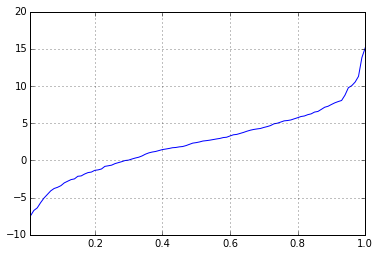

In [202]:
differences.quantile([i / 100 for i in range(1, 101)]).plot()

### Variability (with no effect)

In [244]:
differences_null = []
for i in range(500):
    means = run_weight_loss_trial(40, 0, gaussian=False).groupby('treatment').mean()
    lost = means.ix[False] - means.ix[True]
    differences_null.append(float(lost))

differences_null = pd.Series(differences_null)
differences_null.abs().mean()

3.3690160428768134

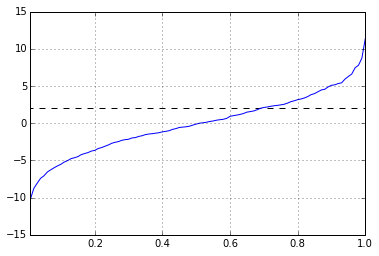

In [243]:
fig, ax = plt.subplots()
differences_null.quantile([i / 100 for i in range(1, 101)]).plot(ax=ax)
ax.hlines([2], xmin=0, xmax=1, linestyles='dashed')

In [208]:
differences_null.quantile(.95)

6.2805461843499035

## Sample size and significance

How does the sample size affect the size of the effect that we need to see in order to obtain a significant result?

In [259]:
obsese_weights_after_treat = obsese_weights.copy()
obsese_weights_after_treat -= norm(0, 3).rvs(len(obsese_weights_after_treat))


rows = []
for sample_size in (10, 20, 40, 60, 80, 100, 150, 200, 300, 400, 500, 750, 1000, 2000, 5000, 10000, 20000):
    differences = []
    for i in range(500):
        sample1_mean = obsese_weights_after_treat.sample(sample_size // 2).mean()
        sample2_mean = obsese_weights_after_treat.sample(sample_size // 2).mean()
        rows.append({'sample_size': sample_size, 
                     'mean_diff': sample1_mean - sample2_mean})
        
differences_df = pd.DataFrame(rows)
differences_df.head()

,mean_diff,sample_size
0,-6.425127,10
1,7.652169,10
2,5.027618,10
3,-3.998249,10
4,-1.366542,10


In [260]:
differences_df.groupby('sample_size').quantile(.95)

,mean_diff
sample_size,
10,14.459973
20,9.753043
40,6.568048
60,5.807816
80,4.622486
100,4.420284
150,3.479545
200,2.841687
300,2.291620


In [261]:
mean_diff_abs = differences_df['mean_diff'].abs()
mean_diff_abs.groupby(differences_df.sample_size).mean()

sample_size
10       6.412319
20       4.774896
40       3.196073
60       2.721311
80       2.438814
100      2.033562
150      1.727511
200      1.396598
300      1.150707
400      1.040933
500      0.989221
750      0.767908
1000     0.671955
2000     0.486326
5000     0.288440
10000    0.206071
20000    0.136674
Name: mean_diff, dtype: float64

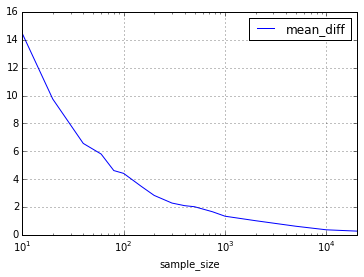

In [262]:
differences_df.groupby('sample_size').quantile(.95).plot(logx=True)